## Camille Porter 

When simulating data in a regression setting, a couple of things should be kept in mind.

Data is simulated from the model y = X β + ε , where y ∈ R^n are the responses, X ∈ R^(n × p) contains the features,  β ∈ R^p is a vector of coefficients, and ε ∈ R^n is a vector of residual noise. A strategy to simulate data from the model is to 
    1. Simulate β ∼ N ( 0 , I_p ) entry-wise. 
    2. Simulate each entry of X from a normal distribution with mean zero [leads to features being somewhat centered around 0]. The standard deviation can be 1 or potentially 1/sqrt(p). The latter avoids that Xβ has quite large values.
    3. Modify β according to the instructions in the assignments.
    4. The noise ε ∼ N (0 , σ^2 I_n) determines the so-called signal-to-noise ratio of the "true" signal X β to the noise ε. It is calculated as the standard deviation of Xβ divided by the standard deviation of ε, in short with constants canceling out SNR = ‖Xβ‖_2 / ‖ε‖_2 . It is possible and desirable to control the signal-to-noise ratio of simulated data. One possibility is to choose σ and then  observe the SNR to see if it is reasonable. Another is to choose σ such that the generated data has SNR close to a target. Let γ be the target level for the SNR, then σ = sqrt( ‖X β‖ 2 2 / (n−1) )/ γ.
    5. Set y = X β + ε which is the observed response. If σ is chosen as described above, then the SNR of y is γ .


The idea of this assignment is to explore how robust the group lasso is to misspecification of groups. In an actual data analysis, it might be known that features are grouped but the groups might not be very clear. For example, groups of people in a social study could be their family, circle of friends, colleagues, ... In addition to the fact that there are many different groupings, it is also not always clear where to end the group. Is a consultant working for a different company but sitting in your office a colleague?

Throughout this assignment, simulate data from a linear regression model, as described in the link above, with groups of coefficients that are either all zero or all non-zero. 

Address the following topics:

    1. Benchmark first the performance of the group lasso when the correct groups are given to the group lasso procedure. As long as n is sufficiently large and the SNR is reasonable (>= 10) the original zero groups should be set to zero and analogously for the original non-zero groups.
    2. What happens when you change the groups, i.e. when you pass the wrong group assignments to the group lasso?
        a. Example: If the correct grouping is 1 1 1 2 2 2 3 3 3, an alternative for a wrong assignment could be 
            1 2 3 1 2 3 1 2 3.
        b. Are there “wrong” group assignments that are less problematic than others?
    3. Explore also the effect of correlation between features in groups and between groups


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from group_lasso import GroupLasso
#  to use lasso based models for variable selection, the regularisation coefficient should 
#  be quite high, resulting in sub-par performance on the actual task of interest. Therefore, 
#  it is common to first use a lasso-like algorithm to select the relevant features before 
#  using another another algorithm (say ridge regression) for the task at hand. 

np.random.seed(0)

In [22]:
'''def generate_data(n, p, mu, sigma):
    #I_p = numpy.matlib.identity(p, dtype=int) #  square identity matrix of size p
    
    # should be matrix of of p x 1, but is 10 x 1
    vector = np.random.default_rng().normal(mu, sigma, (p, 1)) # mean, sd, size

    # I don't know why, but this makes B actually length p (the command before didn't)
    # matrix of p x 1
    Betas = np.array(vector).reshape(p, 1)

    # a matrix of size n x p 
    X = np.random.default_rng().normal(mu, sigma, (n, p))
    
    # a matrix of size n x 1
    epsilon = np.random.default_rng().normal(mu, .1, (n, 1))
    
    # SNR = standard deviation of Xβ divided by the standard deviation of ε
    print("Signal to Noise Ratio is: ", sigma/.1) 

    #y = x*beta + e
    # matrix of size n x 1
    y = numpy.matmul(X, Betas) + epsilon
    
    return X, Betas, epsilon, y
    
    # a matrix of size n x 1
    epsilon = np.random.default_rng().normal(mu, .1, (n, 1))
    
    # SNR = standard deviation of Xβ divided by the standard deviation of ε
    print("Signal to Noise Ratio is: ", sigma/.1) 

    #y = x*beta + e
    # matrix of size n x 1
    y = numpy.matmul(X, Betas) + epsilon
    
    return X, Betas, epsilon, y

n = 500 # number of samples
p = 50 # number of features

mu, sigma = 0, 1
X, Betas, epsilon, y = generate_data(n, p, mu, sigma)
#print(X, "Betas", Betas, "epsilon", epsilon, "y", y)'''

'def generate_data(n, p, mu, sigma):\n    #I_p = numpy.matlib.identity(p, dtype=int) #  square identity matrix of size p\n    \n    # should be matrix of of p x 1, but is 10 x 1\n    vector = np.random.default_rng().normal(mu, sigma, (p, 1)) # mean, sd, size\n\n    # I don\'t know why, but this makes B actually length p (the command before didn\'t)\n    # matrix of p x 1\n    Betas = np.array(vector).reshape(p, 1)\n\n    # a matrix of size n x p \n    X = np.random.default_rng().normal(mu, sigma, (n, p))\n    \n    # a matrix of size n x 1\n    epsilon = np.random.default_rng().normal(mu, .1, (n, 1))\n    \n    # SNR = standard deviation of Xβ divided by the standard deviation of ε\n    print("Signal to Noise Ratio is: ", sigma/.1) \n\n    #y = x*beta + e\n    # matrix of size n x 1\n    y = numpy.matmul(X, Betas) + epsilon\n    \n    return X, Betas, epsilon, y\n\nn = 500 # number of samples\np = 50 # number of features\n\nmu, sigma = 0, 1\nX, Betas, epsilon, y = generate_data(n, p, m

In [147]:
def generate_data(n, mu, sigma, noise_std, group_number, group_size):
    
    # n should be divisible by group_size
    if(n%group_size !=0):
        raise ValueError('n should be evenly divisible by group_size')
    
    # return a vector of group_number groups of 20
    group_sizes = [group_size for i in range(group_number)]
    #[np.random.randint(10, 20) for i in range(group_number)]
    
    #returns a vector of size group_number * group_size of 0 or 1 for if the group was active
    active_groups = [np.random.randint(2) for _ in group_sizes]
    
    #creates group_number groups
    groups = np.concatenate(
            [size * [i] for i, size in enumerate(group_sizes)]
            ).reshape(-1, 1)
    
    p = sum(group_sizes) # num_coeffs
    
    # a matrix of size n x p 
    X = np.random.default_rng().normal(mu, sigma, (n, p))
    
    # generate coefficients
    w = np.concatenate(
        [
        np.random.standard_normal(group_size) * is_active
        for group_size, is_active in zip(group_sizes, active_groups)
        ]
    )
    
    w = w.reshape(-1, 1)
    
    true_coefficient_mask = w != 0
    intercept = 2

    # generate regression targets
    y_true = X @ w + intercept
    y = y_true + np.random.randn(*y_true.shape) * noise_std
    
    return X, y, y_true, w, groups, intercept

In [135]:
def plot_R2(y, y_true):
    # view data and compute R2 
    plt.figure()
    plt.plot(y, y_true, ".")
    plt.xlabel("Noisy targets")
    plt.ylabel("Noise-free targets")
    # Use noisy y as true because that is what we would have access
    # to in a real-life setting.
    R2_best = r2_score(y, y_true)
    
    return R2_best

In [159]:
# generate estimator and train
def estimate(groups, X, y, R2_best):
    gl = GroupLasso(
        groups=groups,
        group_reg=5,
        l1_reg=0,
        frobenius_lipschitz=True,
        scale_reg="inverse_group_size",
        subsampling_scheme=1,
        supress_warning=True,
        n_iter=1000,
        tol=1e-3,
    )
    gl.fit(X, y)

    # Extract info from estimator
    yhat = gl.predict(X)
    sparsity_mask = gl.sparsity_mask_
    w_hat = gl.coef_
    print(w_hat)

    # Compute performance metrics
    R2 = r2_score(y, yhat)

    # Print results
    print(f"Number variables: {len(sparsity_mask)}")
    print(f"Number of chosen variables: {sparsity_mask.sum()}")
    print(f"R^2: {R2}, best possible R^2 = {R2_best}")
    
    return w_hat, gl

In [ ]:
# Explore also the effect of correlation between features in groups and between groups

# make a correlation matrix

[[ 3.42211480e-01]
 [-3.52948192e-01]
 [-6.58075259e-01]
 [ 3.47525384e-01]
 [-6.72638937e-01]
 [ 3.20009328e-01]
 [ 1.93822365e+00]
 [ 4.94257046e-01]
 [ 3.77424092e-02]
 [ 9.33900726e-02]
 [ 1.89309084e-01]
 [-3.72688729e-01]
 [-2.70956979e-01]
 [-2.91842277e-01]
 [ 2.71025510e-01]
 [-1.08274734e+00]
 [ 1.17408223e+00]
 [-8.90570605e-02]
 [ 1.64409422e-01]
 [-3.85552463e-01]
 [-3.95687297e-01]
 [-4.91511029e-02]
 [-3.74467155e-01]
 [ 4.84499128e-01]
 [ 5.72020679e-01]
 [-1.03522128e-01]
 [ 1.18842554e-01]
 [-4.64261244e-02]
 [-1.30402313e-01]
 [-6.45437336e-01]
 [-3.77178726e-01]
 [ 2.92115123e-01]
 [-4.74862989e-01]
 [-4.85705557e-02]
 [ 3.81911687e-01]
 [ 4.48832743e-03]
 [-1.09238921e-02]
 [ 6.78149693e-02]
 [ 1.77236189e-03]
 [ 6.25798651e-01]
 [ 2.32743466e+00]
 [-8.98274332e-01]
 [-1.93006237e-01]
 [ 1.39312534e-01]
 [-4.18792116e-03]
 [ 4.47834731e-01]
 [-2.50314412e-01]
 [-4.54046827e-01]
 [ 7.66026984e-01]
 [ 2.40447329e-01]
 [-4.31920424e-01]
 [-5.13231196e-01]
 [ 4.1576257

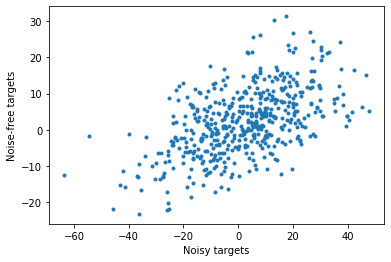

In [160]:
n = 500 # num_datapoints
noise_std = 15
mu, sigma = 0, 1
group_number = 6
group_size = 20
# n should be divisible by group_size
X, y, y_true, w, groups, intercept = generate_data(n, mu, sigma, noise_std, group_number, group_size)

R2_best = plot_R2(y, y_true)


group = [np.random.randint(0,group_number) for i in range(len(groups))]
#print(len(groups))

w_hat, gl = estimate(group, X, y, R2_best)

X shape: (500, 120)
True intercept: 2
Estimated intercept: [2.47975028]


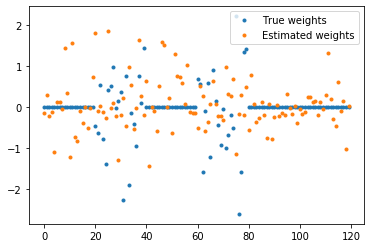

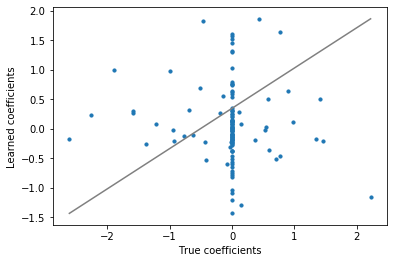

In [156]:
# visualize regression coefficients

plt.figure()
plt.plot(w, ".", label="True weights")
plt.plot(w_hat, ".", label="Estimated weights")
plt.legend()

plt.figure()
plt.plot([w.min(), w.max()], [w_hat.min(), w_hat.max()], "gray")
#plt.plot([-1,-1], [1,1], "gray")
plt.scatter(w, w_hat, s=10)
plt.ylabel("Learned coefficients")
plt.xlabel("True coefficients")

#plg.figure()
#plt.plot(w_hat, )

'''
plt.figure()
plt.plot(gl.losses_)
plt.title("Loss plot")
plt.ylabel("Mean squared error")
plt.xlabel("Iteration")'''

print("X shape: {X.shape}".format(X=X))
print("True intercept: {intercept}".format(intercept=intercept))
print("Estimated intercept: {intercept}".format(intercept=gl.intercept_))
plt.show()